# Heat equation - Retrieving operator through ODE solving

In [1]:
# Import packages
import os
import argparse
import time
import numpy as np
import pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from torchdiffeq import odeint_adjoint as odeint

from graphic_tools import simple_plotter, show_state, animate_plot
from heat import get_heat, get_heat_grad_t, get_heat_fd, get_heat_fd_impl
from generators import heat_snapshot_generator, get_heat_batch
from initial_functions import random_init, high_dim_random_init, heat_analytical_init
from analysis_tools import downsampling
from training_dataset import generate_heat_training_dataset, read_dataset

## Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

<IPython.core.display.Javascript object>


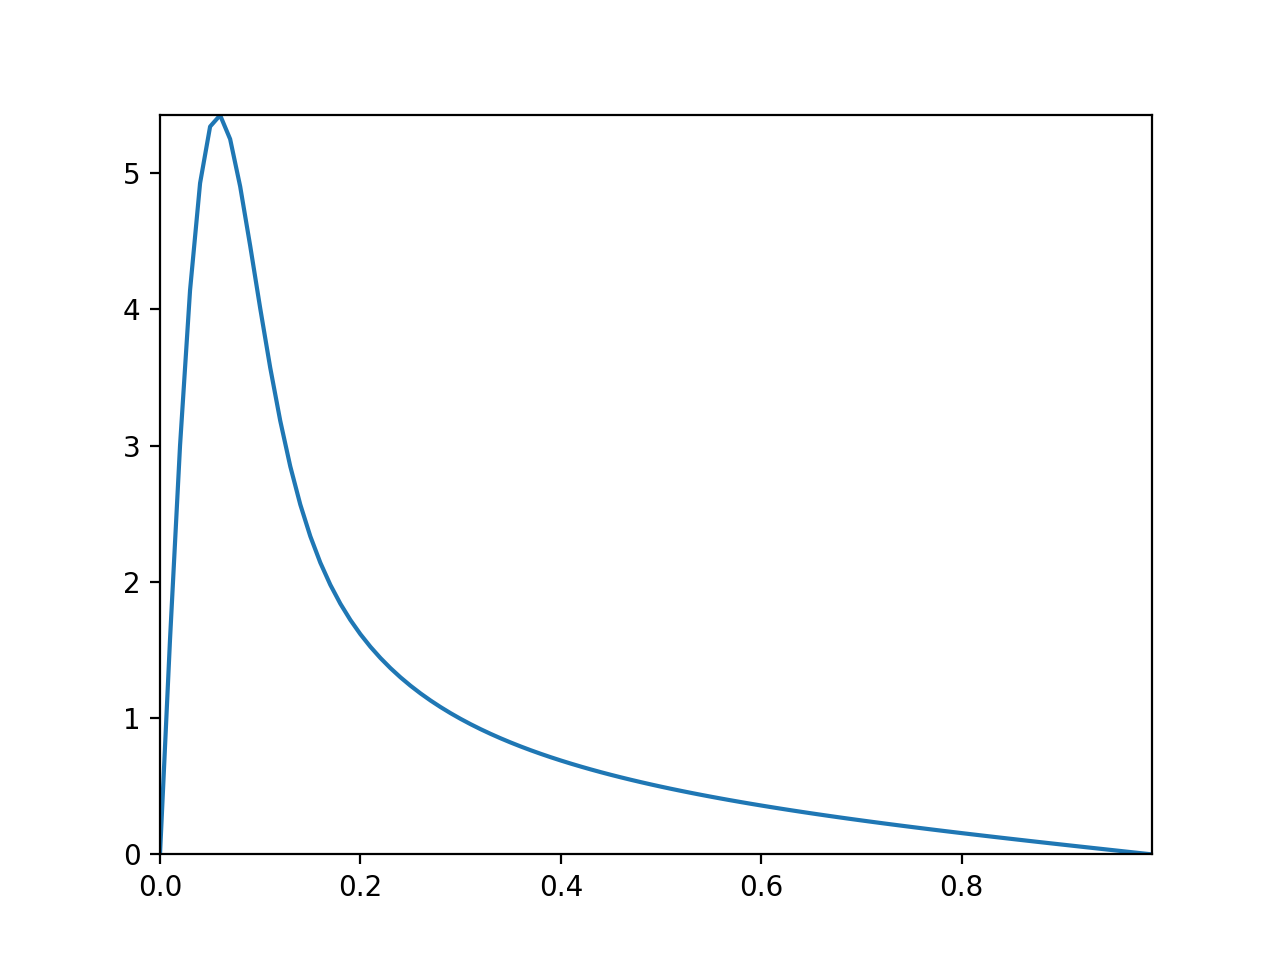

In [2]:
%matplotlib notebook

u_true, cn = get_heat(0.01, 0.001, 1., 0., 50, 100, False)
g_u_true = get_heat_grad_t(0.01, 0.001, 1., 0., 20, 50, cn)

x = np.arange(0.0, 1.0, 0.01)
outer_ani = animate_plot(u_true, x)

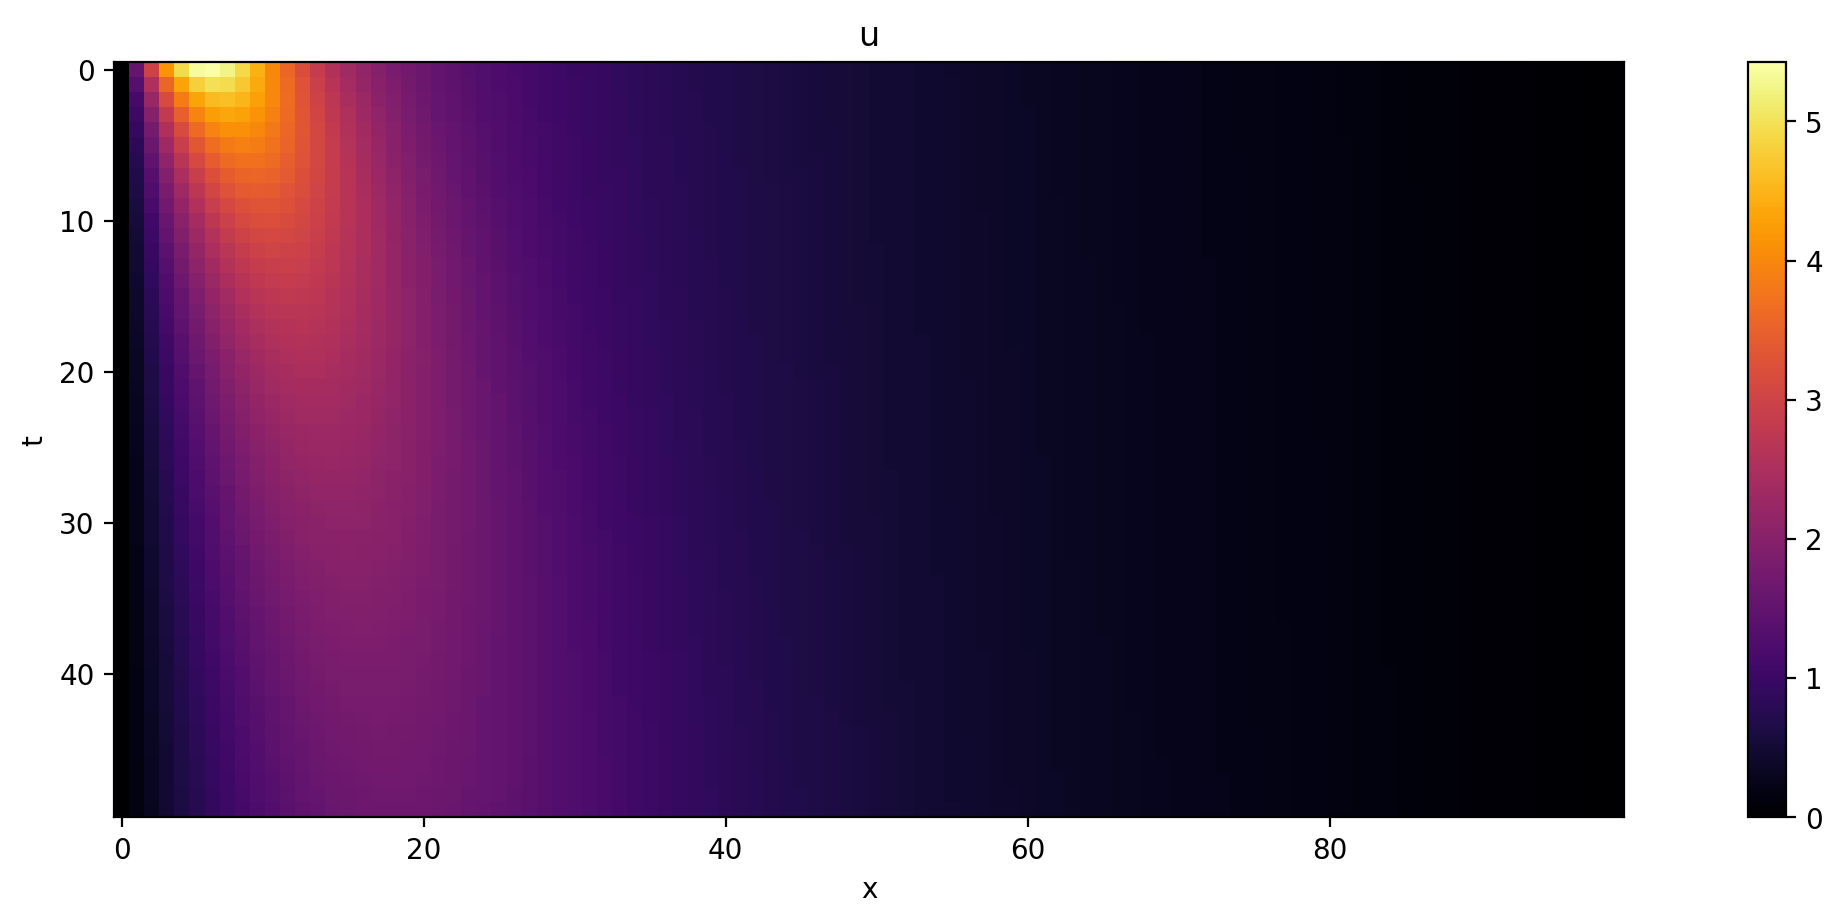

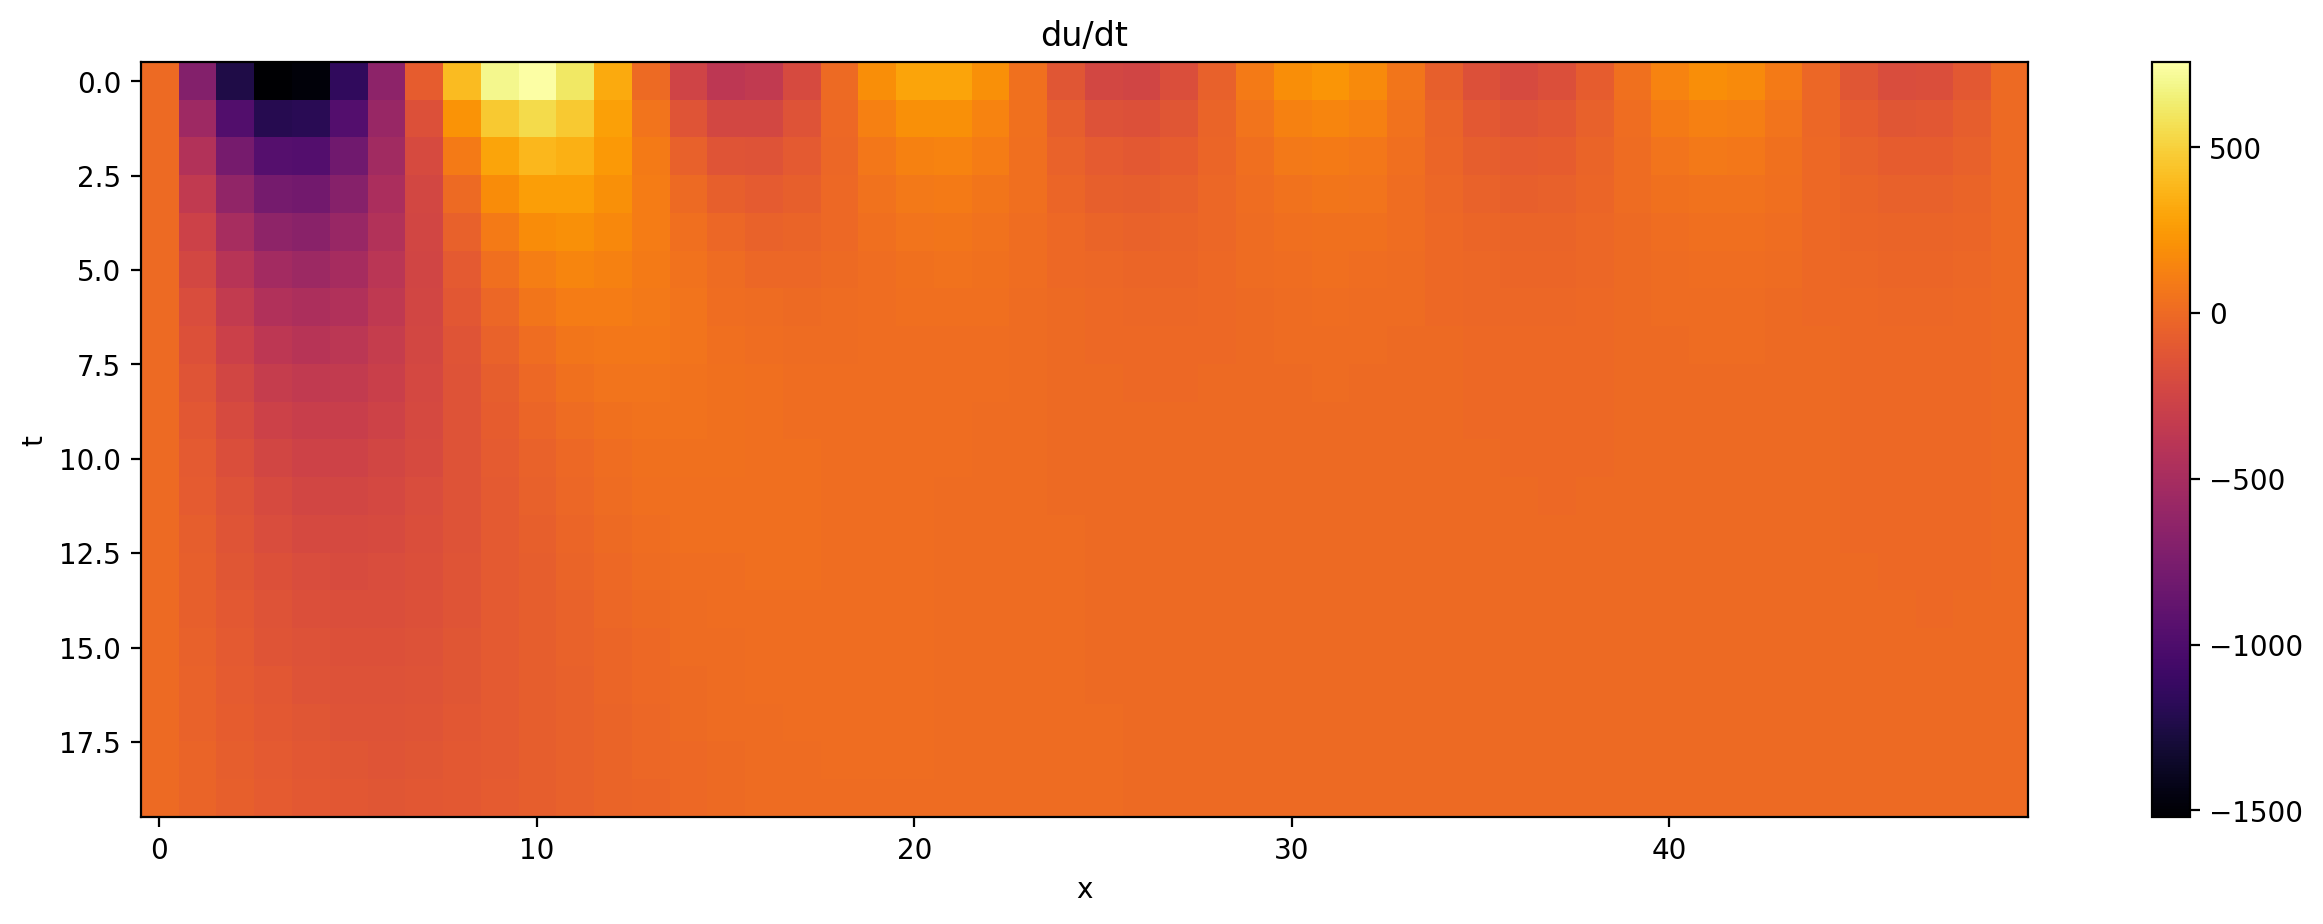

In [3]:
%matplotlib inline
show_state(u_true, 'u')
show_state(g_u_true, 'du/dt')

### Different methods

We make usage of different method to evaluate a solution to the heat equation. Starting from the well-known analytical solution to the equation $u(x,t) = \sum^{\inf}_{n=1} c_n e^{-\pi^2 n^2 t} sin(n \pi x)$,
we implemented as well a finite-difference and finite-element solution.

While for testing the quality of our implementation we started with the analytical solution, in the case of heat equation it is interesting to continue with the finite-difference, which (as seen below) provides more interesting results than the finite-element version. The latest one might be of better interest on a 2D heat or non-linear equation such as Burgers.

In [4]:
t_max = 0.5
t_min = 0.01
x_max = 1.
x_min = 0.
t_n = 64
x_n = 64

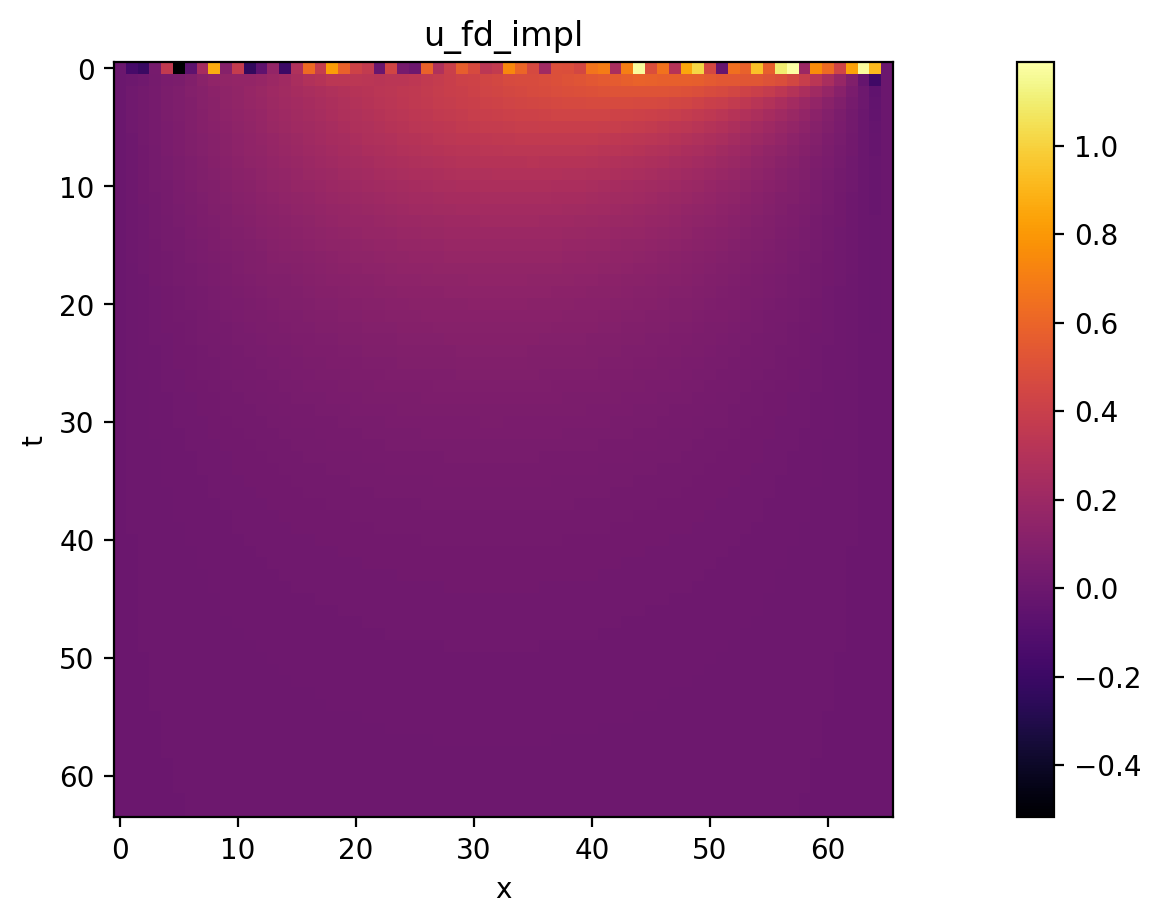

In [5]:
t, dt = np.linspace(t_min, t_max, t_n, retstep=True)
x, dx = np.linspace(x_min, x_max, x_n, retstep=True)

u0 = random_init(t, x)
# u_fd, _ = get_heat_fd(dt, dx, t_n, x_n, u0)
u_fd_impl, _ = get_heat_fd_impl(dt, dx, t_n, x_n, u0)

# # Keep initial conditions. Change if start from t=1
# show_state(u_fd, 'u_fd')
show_state(u_fd_impl, 'u_fd_impl')

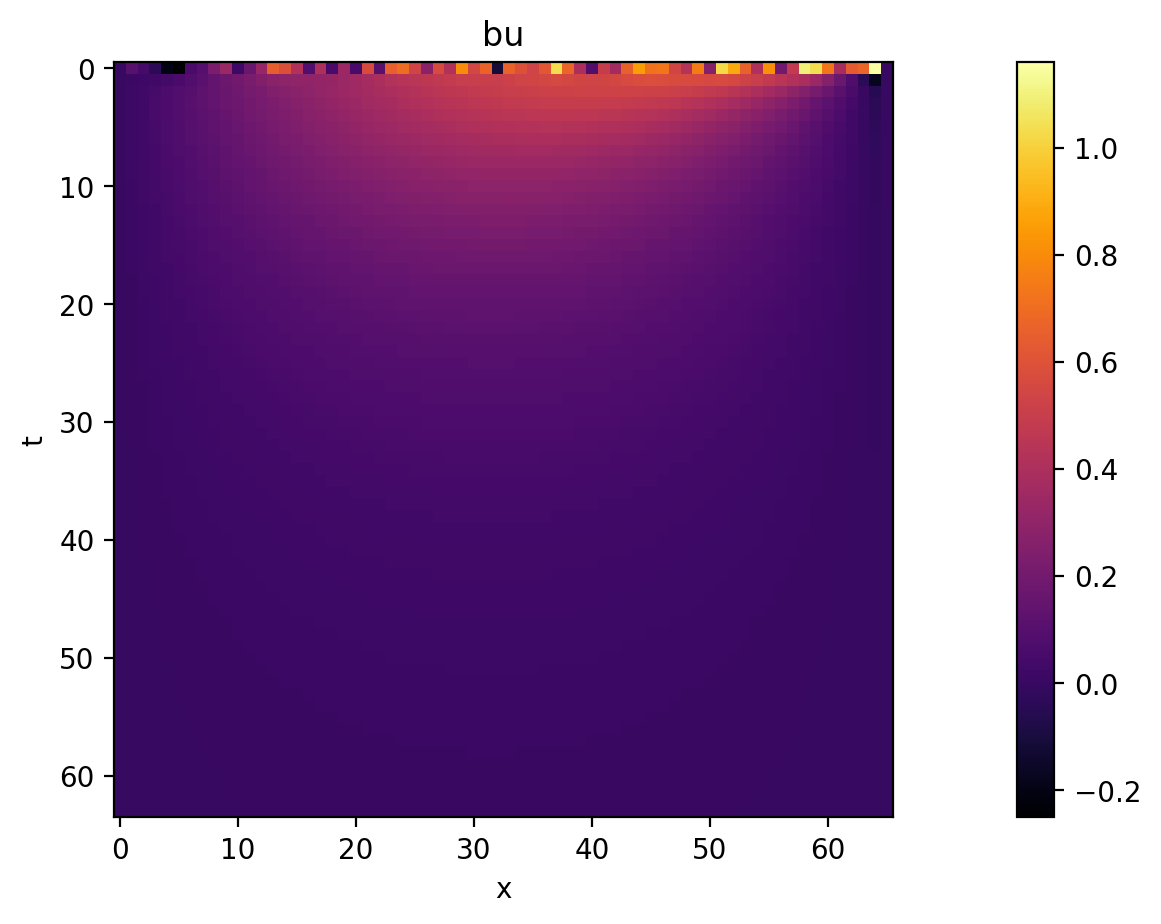

In [6]:
_, _, bu = get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, -1, 0)
# Keep initial conditions. Change if start from t=1
show_state(bu, 'bu')

---

## Operator F reconstruction

In [7]:
# training_set = generate_heat_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, 256, 0, './dataset/random_heat_training_set.pt')
training_set = read_dataset('dataset/random_heat_training_set.pt')

#### Model used by ODE solver

In [8]:
class ODEModel(nn.Module):
    def __init__(self, n=500):
        super(ODEModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n, n),
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, u):
        return self.net(u)

### Implementation of the neural ODE

Let's now write our neural ODE. In a first time we will generate some data and
process them in a format usable by PyTorch and the ODESolver (torchdiffeq).

Let's write a small training loop for our neural ode.

In [9]:
def dudt(u, dt):
    return u[1:, :] - u[0:-1, :] / dt

In [10]:
def get_batch(t_max, t_min, x_max, x_min, t_n, x_n, x_batch_size, rand=False):
    t_batch_size = t_n
    
    # We generate our time and space axis
    t_range = np.linspace(t_min, t_max, t_batch_size)

    # Then compute a snapshot of the solution u(t, x).
    u, _ = get_heat(t_max, t_min, x_max, x_min, t_n, x_n, rand)
    u_t = torch.from_numpy(u).float() # Convert to Tensor [1:,:]
    
    rand_idx = np.random.choice(np.arange(x_n, dtype=np.int64), x_batch_size, replace=False)
    rand_idx = np.sort(rand_idx)
    
    # Get the set of time values from the t-axis used by ODE solver.  dimension (t_max)
    batch_t = torch.from_numpy(t_range).float()
    
    batch_u0 = u_t[0, rand_idx,]  # Get u(0, x)
    batch_u = torch.stack([u_t[i, rand_idx] for i in range(0, t_batch_size)], dim=0)
    
    return batch_t, batch_u0, batch_u

def old_training_ode_solver_net(net, epochs=100, t_n=20, x_n=100, batch_size=10, val_epoch=10, rand=False):
    loss_fn = nn.MSELoss()
    optimizer = optim.RMSprop(net.parameters(), lr=0.003)

    for e in range(1, epochs + 1):
        loss_tot = 0
        val_loss_tot = 0
        
        net.train()
        for i in range(int(x_n / batch_size)):
            optimizer.zero_grad()
            t, _, bu = get_heat_batch(t_max,t_min, x_max, x_min, t_n, x_n, -1, 0)
            b0 = bu[1, :]
            pred_u = odeint(net, b0[1:-1], t[1:]) # , method='dopri5'
            loss = loss_fn(pred_u, bu[1:,1:-1])
            loss_tot += loss.item()
            
            loss.backward(retain_graph=True)
            optimizer.step()

        if e % 10 == 0:
            t, _, bu = get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, -1, 0)
            b0 = bu[1, :]
            visualize_u_from_F(net, t[1:], bu[1:,1:-1], b0[1:-1])
            
            print('epoch %d loss %f'%(e, float(loss_tot / float(x_n / batch_size))))
    
    return net

net = ODEModel(x_n)
Fo = old_training_ode_solver_net(net, 50, t_n, x_n, x_n, 10, False)

NameError: name 'visualize_u_from_F' is not defined

#### Training loop - ode solver & intrusive training

In [11]:
def loss_fn(pred_x, x):
    return nn.MSELoss(reduction='mean')(pred_x, x)

In [47]:
def training_ode_solver_net(net, epochs, t_n, x_n, dataset, val_epoch=10, rands=[], downsize=0):
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    training_batch_size = len(dataset)
    training_set_idx = np.arange(0, training_batch_size)

    tr_min_t = 1
    tr_max_t = int(len(dataset[0][0]) / 5 * 2)
    val_max_t = int(tr_max_t + len(dataset[0][0]) / 5 * 2)
#     validation_batch_size = int(batch_size / 5 * 2)
#     validation_set_idx = np.arange(training_batch_size, training_batch_size + validation_batch_size)
    
    for e in range(1, epochs + 1):
        loss_tot = 0
        val_loss_tot = 0
        
        
        # === Train ===
        net.train()
        np.random.shuffle(training_set_idx)
        for i in training_set_idx:
            # === Randomness ====
            rand = -1
            if (i < len(rands)):
                rand = rands[i]
    
            optimizer.zero_grad()
            
            t, bu, _, _ = dataset[i]
            tr_t =  t[tr_min_t:tr_max_t]
            tr_b0 = bu[tr_min_t, :]
            tr_bu = bu[tr_min_t:tr_max_t, :]
            
            pred_u = odeint(net, tr_b0, tr_t) # [1:-1]
            loss = loss_fn(pred_u.T, tr_bu.T) # [:, 1:-1]
            loss_tot += loss.item()
            
            loss.backward(retain_graph=True)
            optimizer.step()
        
        print('Epoch %d loss %f'%(e, float(loss_tot / float(training_batch_size))))
        
        # === Evaluate ===
        net.eval()
        if (e > val_epoch):
            for j in training_set_idx:
                t, bu, _, _ = dataset[j]
                val_t = t[tr_max_t:val_max_t]
                val_b0 = bu[tr_max_t, :]
                val_bu = bu[tr_max_t:val_max_t, :]
                
                val_pred_u = odeint(net, val_b0, val_t)
                val_loss = loss_fn(val_pred_u.T, val_bu.T)
                val_loss_tot += val_loss.item()
            print('Epoch %d validation loss %f'%(e, float(val_loss_tot / float(training_batch_size))))
        
        
        if e % 10 == 0:
            sample_t, sample_b0, sample_real = get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, rand, -1)
            sample_b0 = sample_real[1, :]
            sample_pred = odeint(net, sample_b0[1:-1], sample_t[1:])
            show_state(sample_real[1:].T, 'Real', 't', 'x', None)
            show_state(sample_pred.detach().numpy().T, 'Determined', 't', 'x', None)
    
    return net

Epoch 1 loss 0.012412
Epoch 2 loss 0.001975
Epoch 3 loss 0.001381
Epoch 4 loss 0.001320
Epoch 5 loss 0.001274
Epoch 6 loss 0.001228
Epoch 7 loss 0.001181
Epoch 8 loss 0.001135
Epoch 9 loss 0.001085
Epoch 10 loss 0.001036


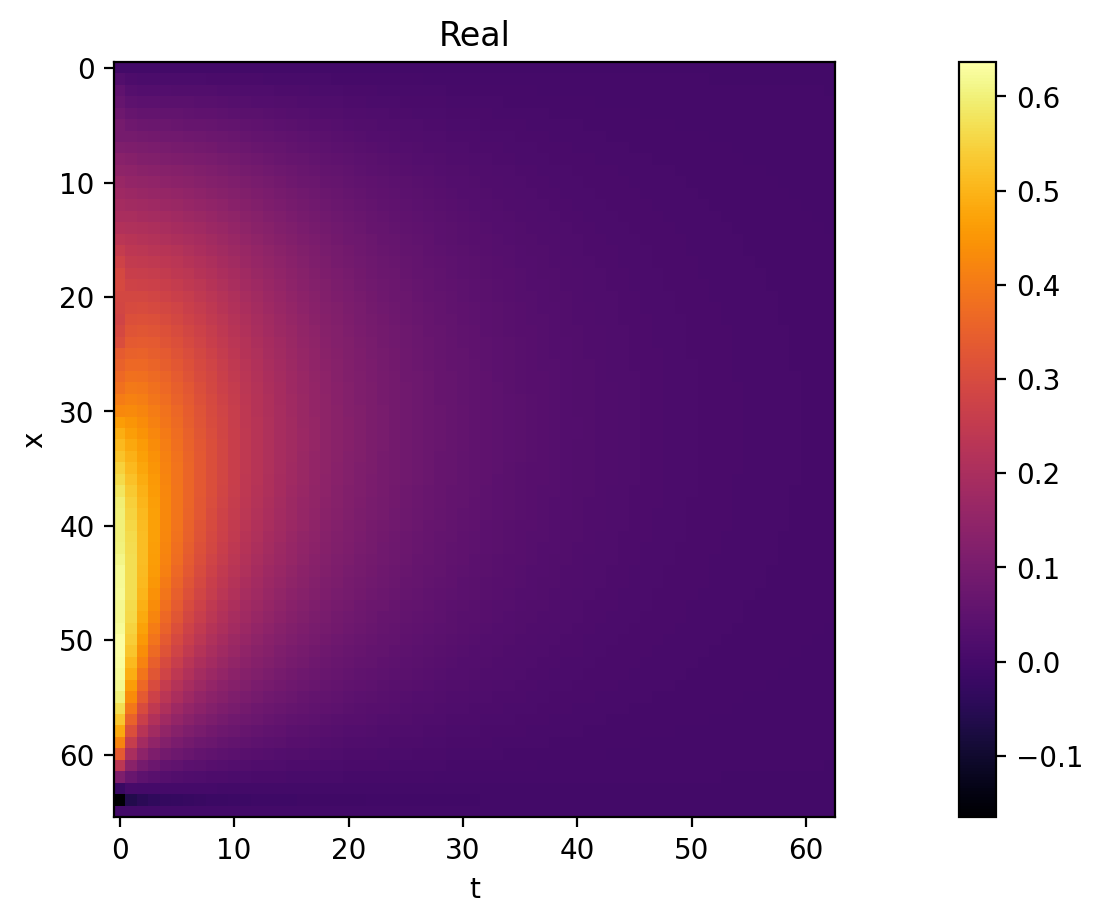

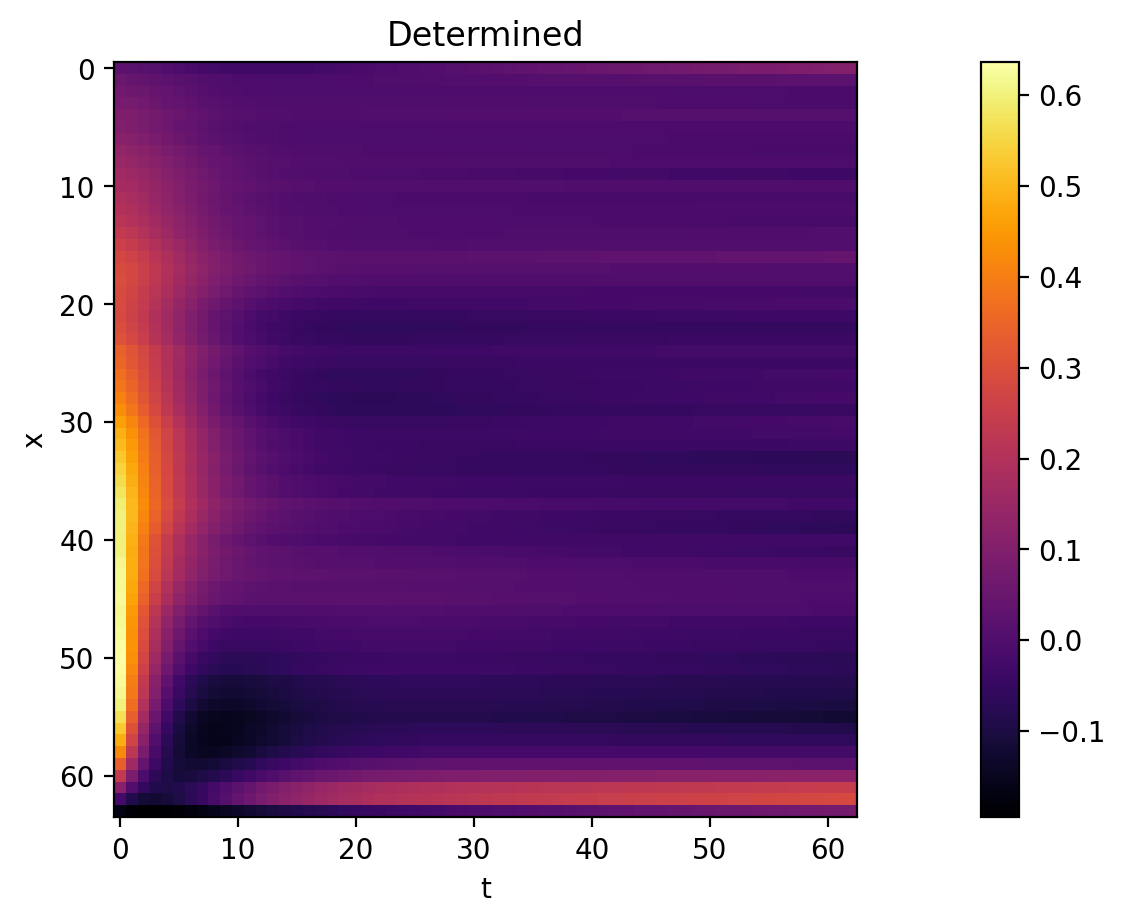

Epoch 11 loss 0.000985
Epoch 11 validation loss 0.001662
Epoch 12 loss 0.000936
Epoch 12 validation loss 0.001419
Epoch 13 loss 0.000885
Epoch 13 validation loss 0.001266
Epoch 14 loss 0.000834
Epoch 14 validation loss 0.001131
Epoch 15 loss 0.000786
Epoch 15 validation loss 0.000976
Epoch 16 loss 0.000736
Epoch 16 validation loss 0.000850
Epoch 17 loss 0.000690
Epoch 17 validation loss 0.000765
Epoch 18 loss 0.000643
Epoch 18 validation loss 0.000666
Epoch 19 loss 0.000599
Epoch 19 validation loss 0.000592
Epoch 20 loss 0.000558
Epoch 20 validation loss 0.000501


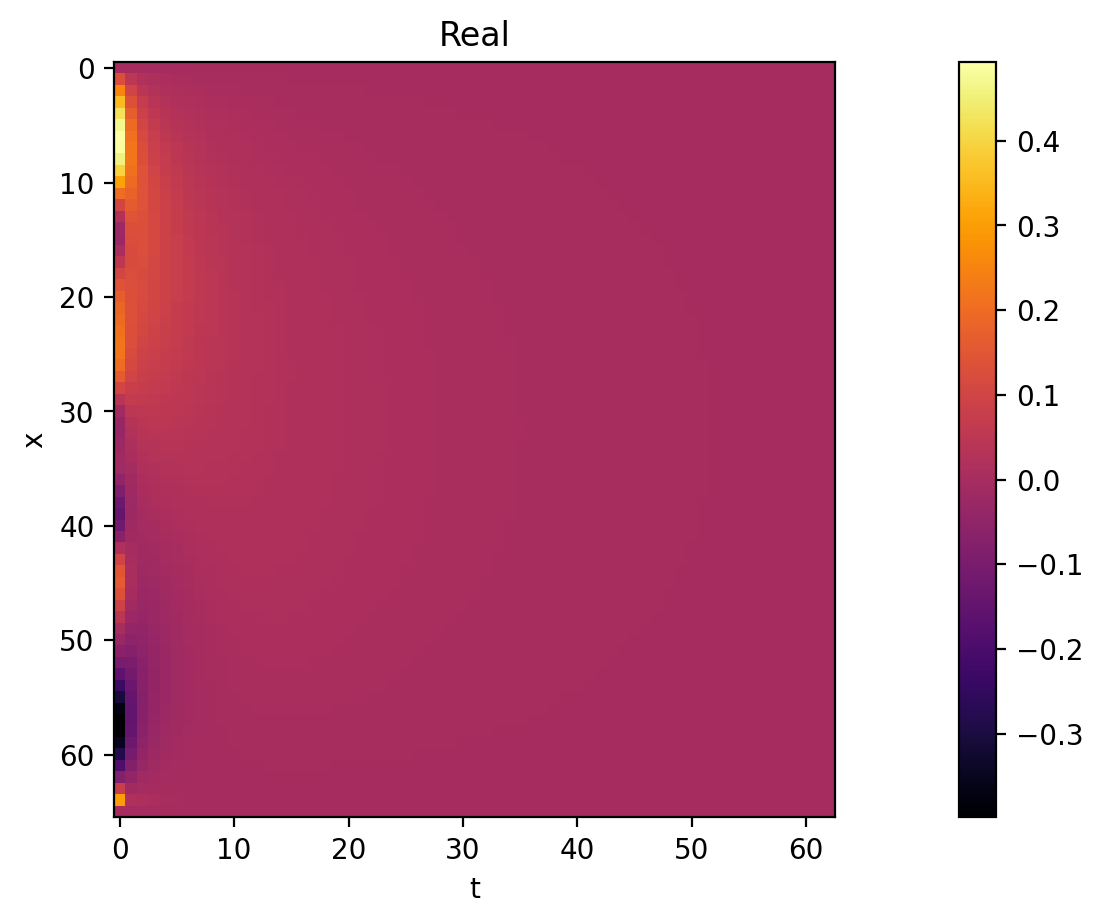

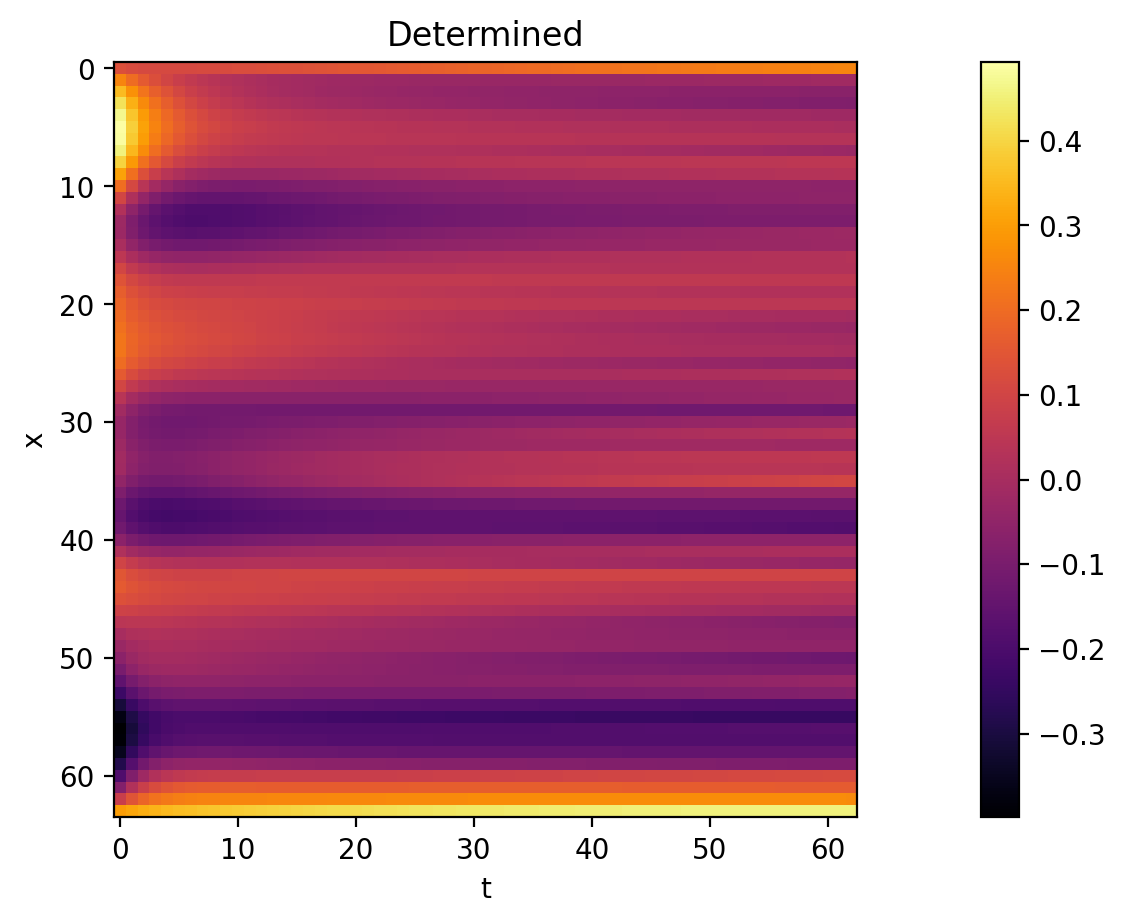

Epoch 21 loss 0.000518
Epoch 21 validation loss 0.000463
Epoch 22 loss 0.000482
Epoch 22 validation loss 0.000401
Epoch 23 loss 0.000447
Epoch 23 validation loss 0.000370
Epoch 24 loss 0.000414
Epoch 24 validation loss 0.000339
Epoch 25 loss 0.000385
Epoch 25 validation loss 0.000312
Epoch 26 loss 0.000358
Epoch 26 validation loss 0.000294
Epoch 27 loss 0.000335
Epoch 27 validation loss 0.000266
Epoch 28 loss 0.000312
Epoch 28 validation loss 0.000283
Epoch 29 loss 0.000290
Epoch 29 validation loss 0.000248
Epoch 30 loss 0.000272
Epoch 30 validation loss 0.000251


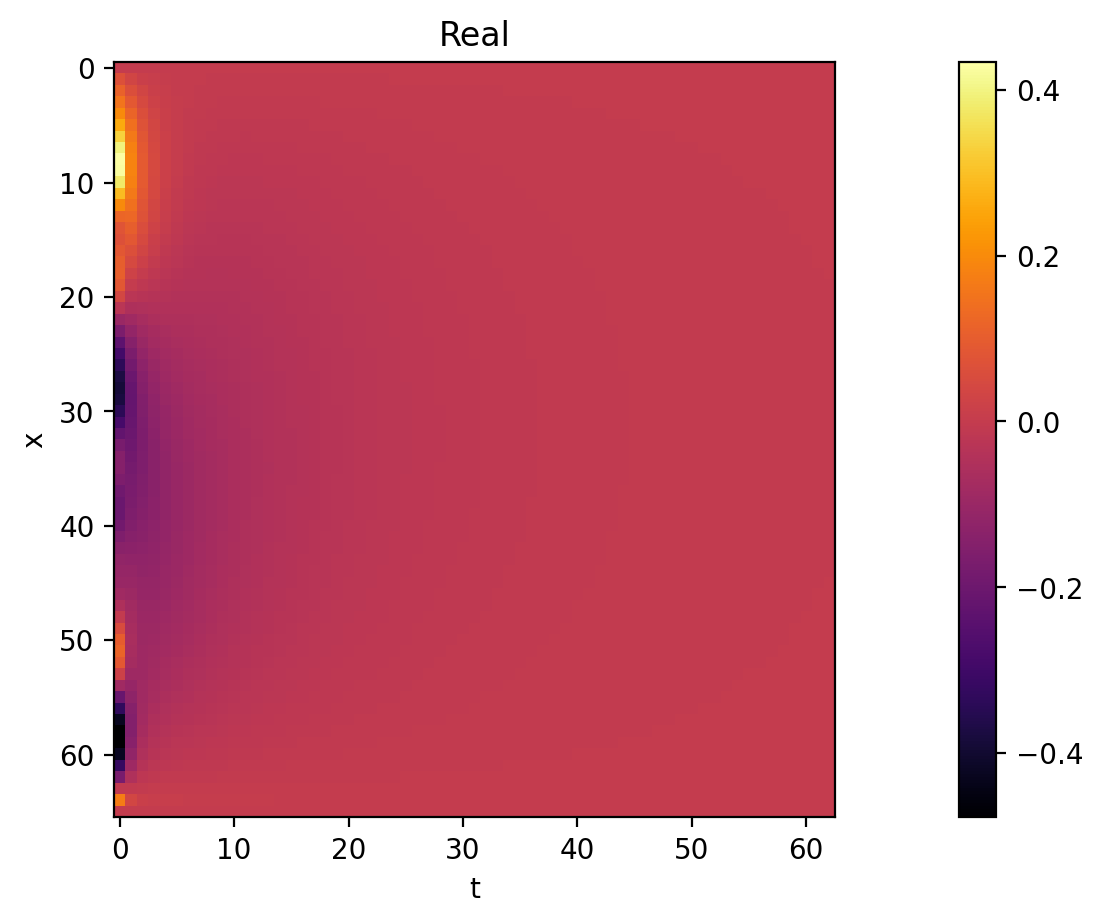

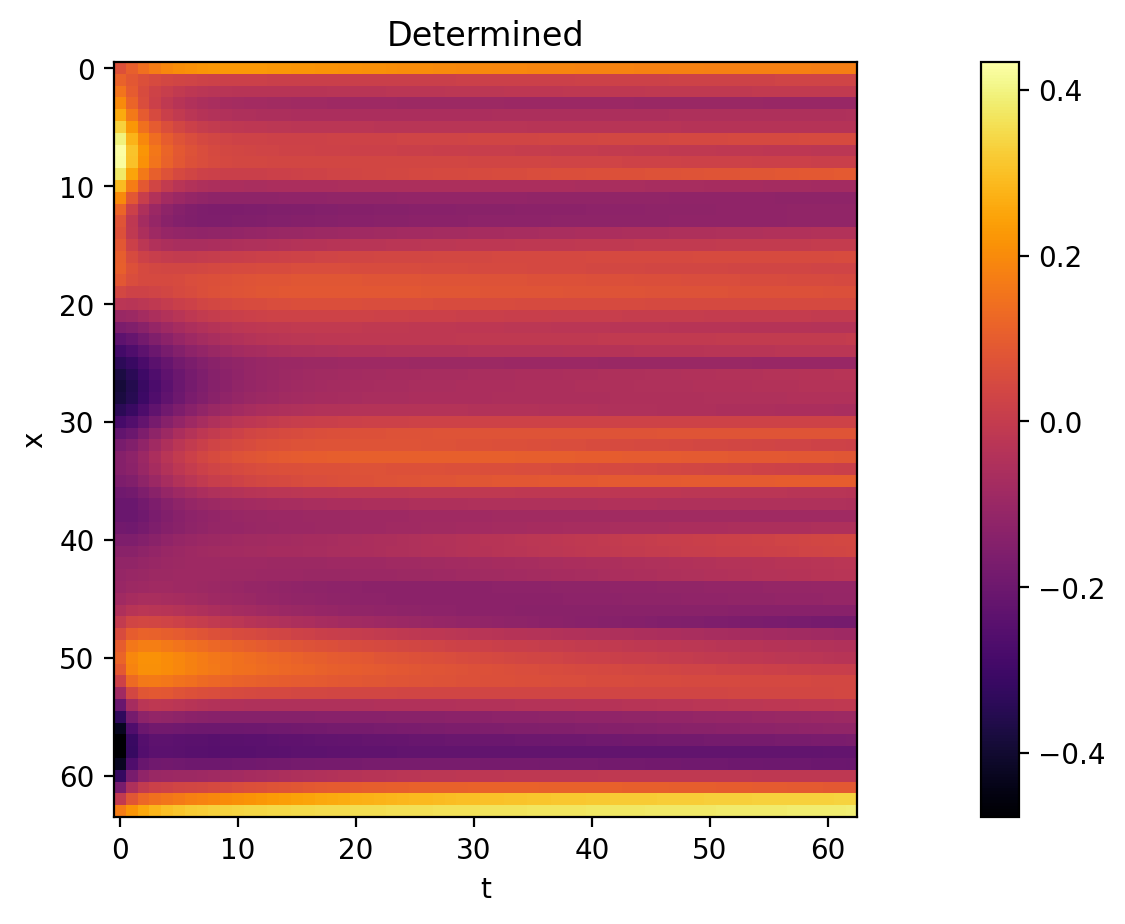

Epoch 31 loss 0.000258
Epoch 31 validation loss 0.000236
Epoch 32 loss 0.000243
Epoch 32 validation loss 0.000231
Epoch 33 loss 0.000228
Epoch 33 validation loss 0.000214
Epoch 34 loss 0.000218
Epoch 34 validation loss 0.000252
Epoch 35 loss 0.000205
Epoch 35 validation loss 0.000238
Epoch 36 loss 0.000197
Epoch 36 validation loss 0.000236
Epoch 37 loss 0.000188
Epoch 37 validation loss 0.000226
Epoch 38 loss 0.000180
Epoch 38 validation loss 0.000242
Epoch 39 loss 0.000171
Epoch 39 validation loss 0.000244
Epoch 40 loss 0.000166
Epoch 40 validation loss 0.000224


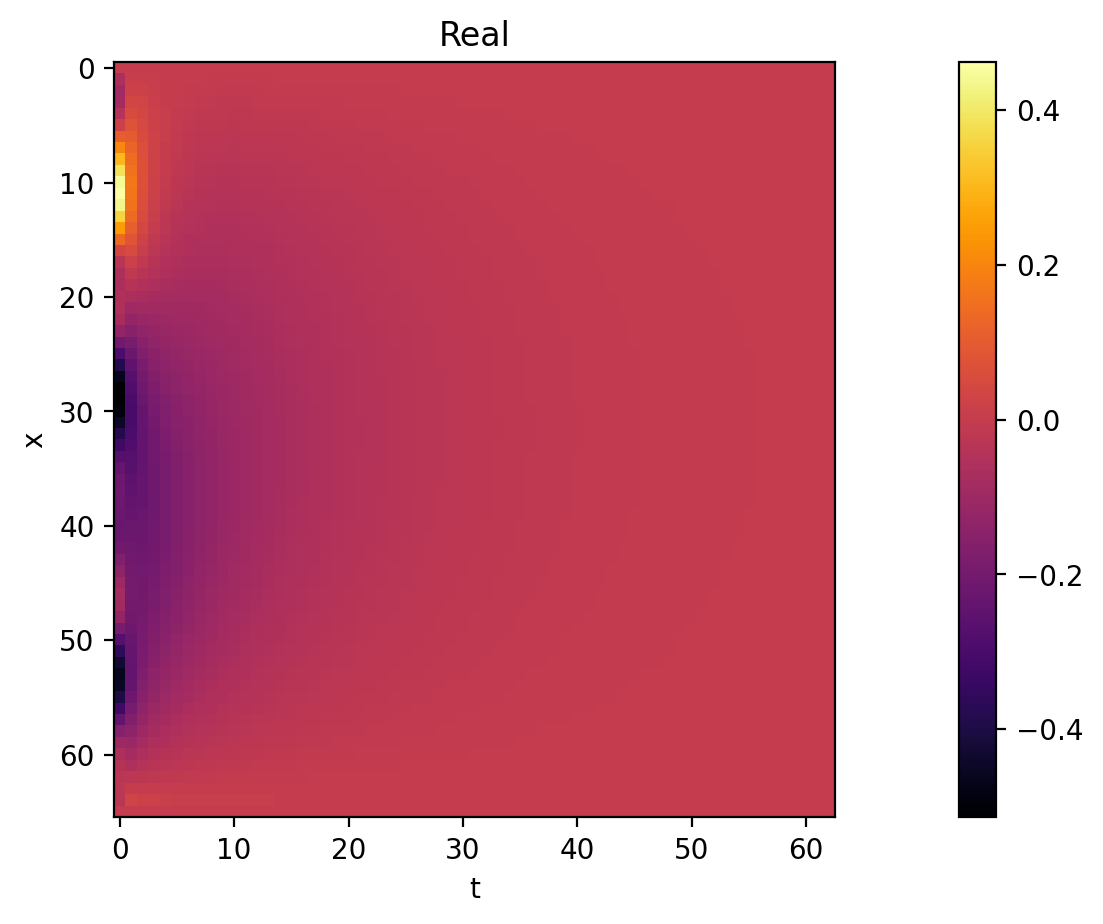

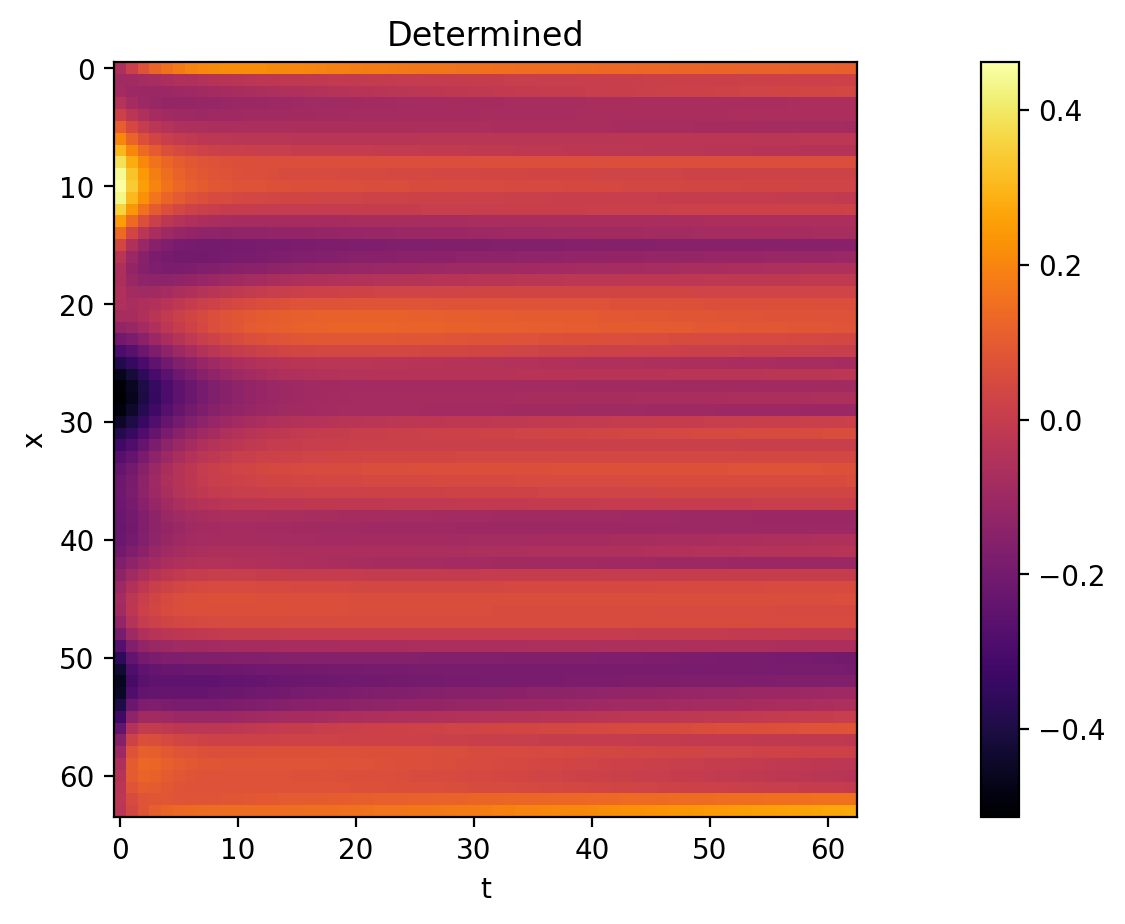

Epoch 41 loss 0.000160
Epoch 41 validation loss 0.000232
Epoch 42 loss 0.000155
Epoch 42 validation loss 0.000242
Epoch 43 loss 0.000150
Epoch 43 validation loss 0.000230
Epoch 44 loss 0.000145
Epoch 44 validation loss 0.000219
Epoch 45 loss 0.000141
Epoch 45 validation loss 0.000209
Epoch 46 loss 0.000136
Epoch 46 validation loss 0.000212
Epoch 47 loss 0.000133
Epoch 47 validation loss 0.000213
Epoch 48 loss 0.000130
Epoch 48 validation loss 0.000201
Epoch 49 loss 0.000127
Epoch 49 validation loss 0.000217
Epoch 50 loss 0.000124
Epoch 50 validation loss 0.000208


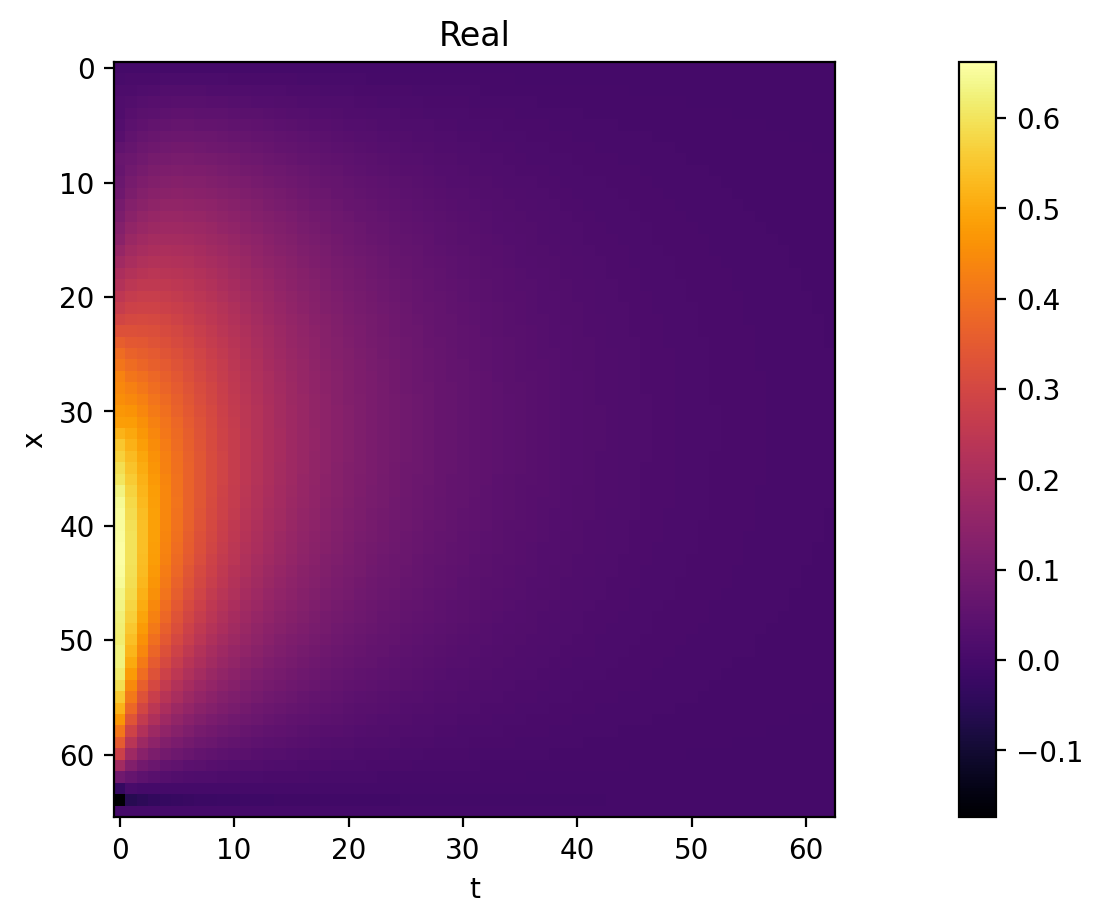

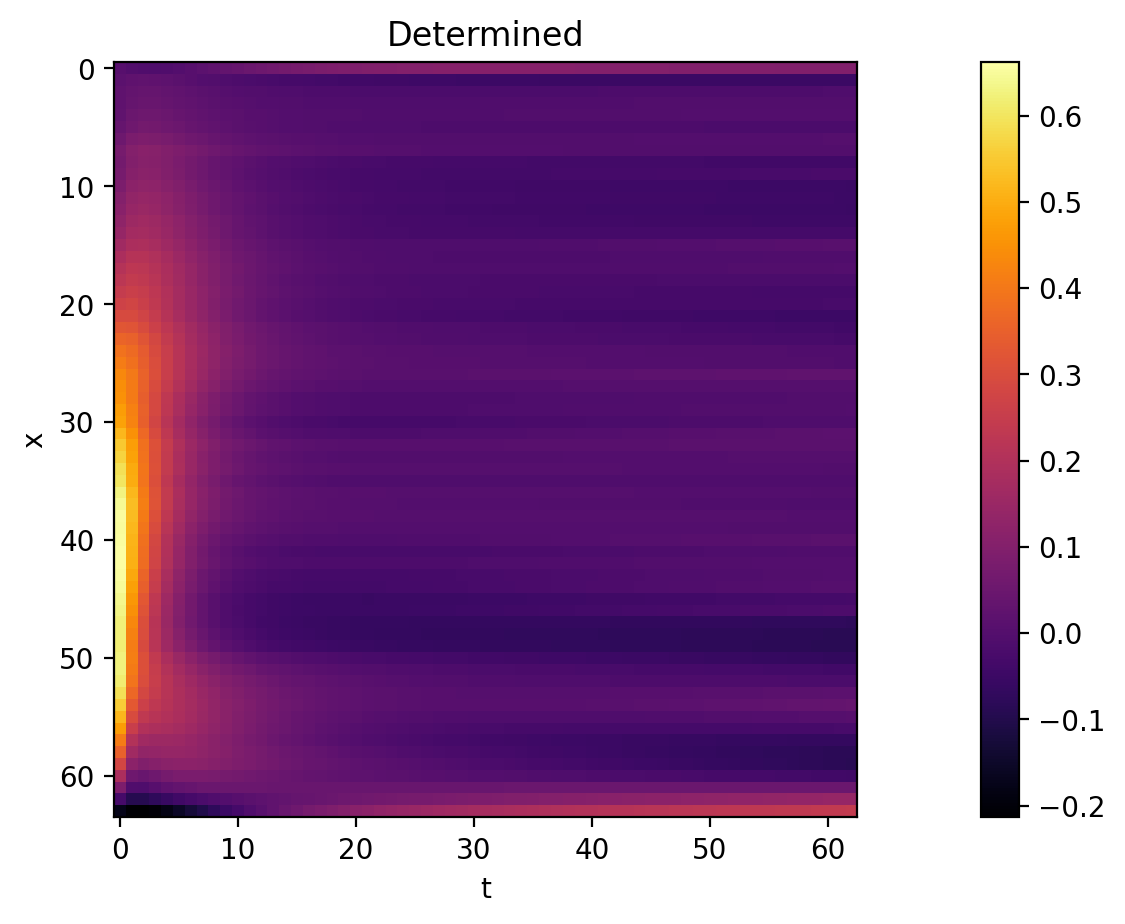

In [48]:
%matplotlib inline
net = ODEModel(x_n)
F = training_ode_solver_net(net, 50, t_n, x_n, training_set, 10, [], 0)

#### Training loop - derivative & non-intrusive training

In [ ]:
def training_ode_solver_net(net, epochs=100, t_n=20, x_n=100, batch_size=10, val_epoch=10, rand=-1):
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    
    for e in range(1, epochs + 1):
        loss_tot = 0
        val_loss_tot = 0
        
        for i in range(batch_size):
            # === Randomness ====
            rand = -1
            if (i < len(rands))
                rand = rands[i]
            
            # === Train ===
            net.train()
            optimizer.zero_grad()
            
            t, b0, bu = get_batch(t_max, t_min, x_max, x_min, t_n, x_n, x_n, rand)
            dudt_ref = dudt(bu[:, 1:-1], (t_max - t_min) / t_n)
            pred_dudt = net([], bu[:-1, 1:-1])
            loss = loss_fn(pred_dudt.T, dudt_ref.T)
            loss_tot += loss.item()
            
            loss.backward(retain_graph=True)
            optimizer.step()

            # === Evaluate ===
            if (e > val_epoch):
                net.eval()
                val_t, val_b0, val_bu = get_batch(t_max, t_min, x_max, x_min, t_n, x_n, x_n, rand)
                val_dudt_ref = dudt(val_bu[:, 1:-1], (t_max - t_min) / t_n)
                val_pred_dudt = net([], val_bu[:-1, 1:-1])
                val_loss = loss_fn(val_pred_dudt.T, val_dudt_ref.T)
                val_loss_tot += val_loss.item()
                
            
        if e % 10 == 0:
            print('Epoch %d loss %f'%(e, float(loss_tot / float(batch_size))))
            print('Epoch %d validation loss %f'%(e, float(val_loss_tot / float(batch_size))))
    
    return net

In [ ]:
%matplotlib inline
net2 = ODEModel(x_n)
F2 = training_ode_solver_net(net2, 300, t_n, x_n, 64, 5, False)

## Visualization

Let's train this basic NN and visualize its efficiency to match the solution u(t,x)

In [ ]:
def visualize_u_from_F(F, t, u, u0):
    pred_u = odeint(F, u0, t).detach().numpy() # time axis is inversed compare to u_true
    show_state(u.T, 'Real', 't', 'x', None)
    show_state(pred_u.T, 'Expected', 't', 'x', None)

In [52]:
def relative_err(u_a, u_b):
    return np.true_divide(np.abs(u_a - u_b), np.abs(u_a))

def rmse(pred_u, real_u):
    return np.mean(np.sqrt((pred_u - real_u)**2))

def check_efficiency(net, n_sim=10, debug=False):
    rmse_tot = 0
    
    for i in range(n_sim):
        t, b0, bu = get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, -1, -1)
        pred_u = odeint(net, b0[1:-1], t).detach().numpy()
        u = bu[:,1:-1].detach().numpy()
        rmse_tot += rmse(pred_u.T, u.T)

        if debug:
            print("RMSE = ", rmse(pred_u.T, u.T))
            show_state(np.abs(pred_u.T - u.T), 'Error NN vs. Real', 't', 'x', None)
            show_state(u.T, 'Real', 't', 'x', None)
            show_state(pred_u.T, 'Expected', 't', 'x', None)
            
    return rmse_tot / n_sim

print(check_efficiency(F, 20, False))

0.33444651067256925


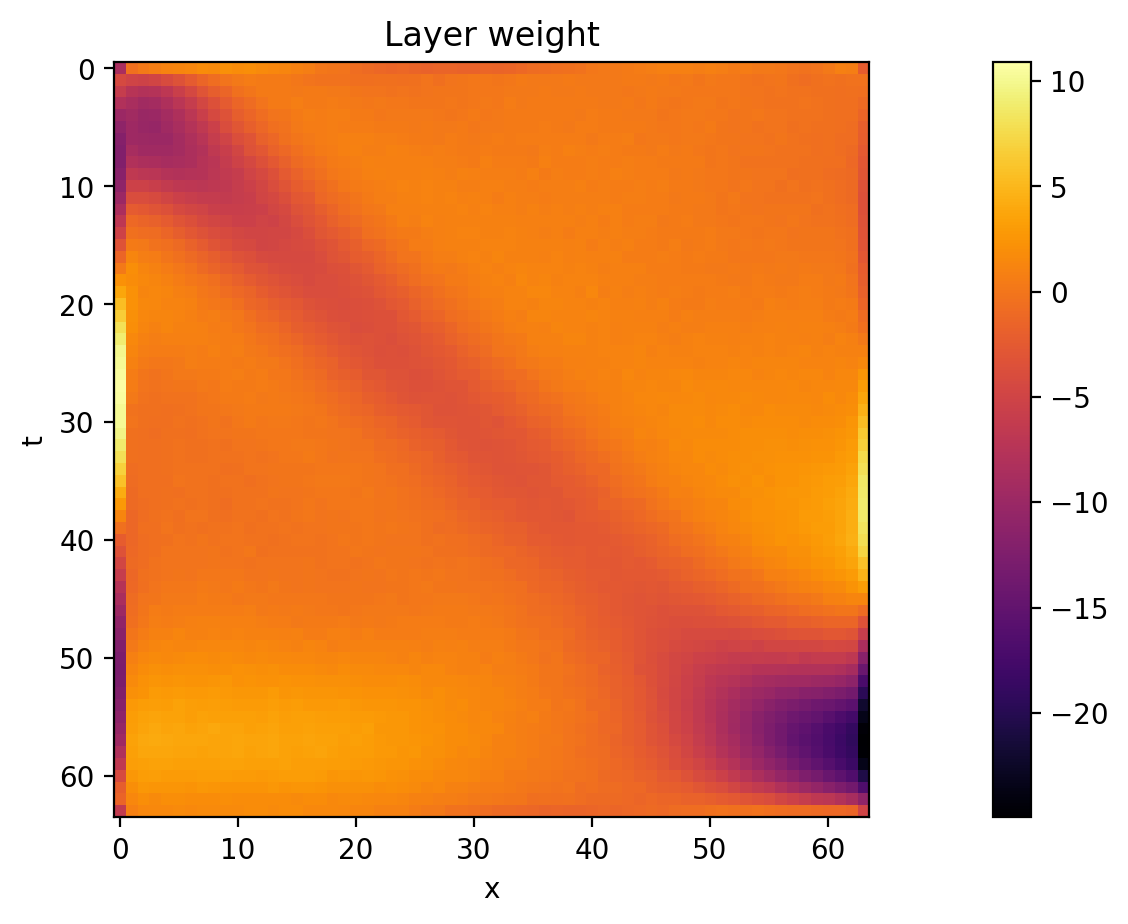

In [50]:
def check_weights(net):
    for name, param in net.named_parameters():
        if 'weight' in name:
            weights = param.detach().numpy()
            show_state(weights, 'Layer weight')

check_weights(F)

In [ ]:
def visualize_F_with_u(F, t_n=20, x_n=100):
    u, x = np.mgrid[-0.2:0.2:10j, 0.:1.:10j]
    grid_xu = torch.from_numpy(np.stack([x, u], -1).reshape(x_n * x_n, 2)).float()
    t = torch.Tensor(np.linspace(0., 1.0, t_n))
    u_m = np.zeros((t_n, x_n * x_n, 2))

    for i in range(1, t_n):
        tmp = F(0, grid_xu).detach().numpy()
        u_m[i] = tmp
    
    color = ['b','r','g','y']
    width=200
    height=150
    
    for i in [5]: # range(1, t_n, 5):
        xlims = (u_m[i, :, 0].min(), u_m[i, :, 0].max())
        ylims = (u_m[i, :, 1].min(), u_m[i, :, 1].max())
        dx = xlims[1] - xlims[0]
        dy = ylims[1] - ylims[0]
        
        buffer = np.zeros((height+1, width+1))
        
        for j, p in enumerate(u_m[i, :, :]):
            x0 = int(round(((p[0] - xlims[0]) / dx) * width))
            y0 = int(round((1 - (p[1] - ylims[0]) / dy) * height))
            buffer[y0, x0] += 0.3
            if buffer[y0, x0] > 1.0: buffer[y0, x0] = 1.0
        
        ax_extent = list(xlims)+list(ylims)
        plt.figure(dpi=150)
        plt.imshow(
            buffer,
            vmin=0,
            vmax=1, 
            cmap=plt.get_cmap('hot'),
            interpolation='lanczos',
            aspect='auto',
            extent=ax_extent)
            
    return u_m

In [ ]:
visualize_F_with_u(F, t_n, x_n)

What is happening here ?
We display du/dt for a set of grid points (t, x) to have an overall idea of the derivative shape.
With the operator F, we provide a different set of values, has we generate grid points (x, u).
While the results will be different, it clearly apppears we do not get the same shapes.


---

## Analysis

We know have a working mock model. It is time to experiment reconstruction through different variants of our problem: 
- Introduce different initial conditions
- Introduce different boundary conditions (Dirichlet, Neumann, Robin)
- Introduce noise
- Switch to a reduce order model (ROM) such as the simple POD.
- Investigate the choice of the NN model.

It would be interesting to evaluates these questions:
- How stable is the inversion considering the noise in temperature and measurement of the flux?
- Which conditions are required to uniquely determine the original data?

#### FOM

Coarse-grid resolution: 
- $t_{max} = 0.2$
- $x_{max} = 1.0$
- $t_n = 100$
- $x_n = 500$

#### Initial conditions

Let's consider these set of initials conditions:
- $u(0, x) = \sum_n^{\inf} c_n e^{-\frac{\pi^2 n^2 t}{L}} sin(\pi n x)$

In order to train properly the network, the initial conditions are already slighly modified through the
random generation of a set of constants $c_n$. However, the overall function remain similar and we could consider introducing different functions.

#### Boundary conditions

- Dirichlet: $u(t, a) = u(t, b) = 0, a <= x <= b$
- Neumann: $u_x(t, a) = u_x(t, b) = 0, a <= x <= b$

In [ ]:
def old_get_batch(t_max, t_min, x_max, x_min, t_n, x_n, x_batch_size, rand=False):
    t_batch_size = t_n
    
    # We generate our time and space axis
    t_range = np.linspace(t_min, t_max, t_batch_size)

    # Then compute a snapshot of the solution u(t, x).
    u, _ = get_heat(t_max, t_min, x_max, x_min, t_n, x_n, rand)
    u_t = torch.from_numpy(u).float() # Convert to Tensor [1:,:]
    
    rand_idx = np.random.choice(np.arange(x_n, dtype=np.int64), x_batch_size, replace=False)
    rand_idx = np.sort(rand_idx)
    
    # Get the set of time values from the t-axis used by ODE solver.  dimension (t_max)
    batch_t = torch.from_numpy(t_range).float()
    
    batch_u0 = u_t[0, rand_idx,]  # Get u(0, x)
    batch_u = torch.stack([u_t[i, rand_idx] for i in range(0, t_batch_size)], dim=0)
    
    return batch_t, batch_u0, batch_u

def old_training_ode_solver_net(net, epochs=100, t_n=20, x_n=100, batch_size=10, val_epoch=10, rand=False):
    loss_fn = nn.MSELoss()
    optimizer = optim.RMSprop(net.parameters(), lr=0.005)

    for e in range(1, epochs + 1):
        loss_tot = 0
        val_loss_tot = 0
        
        net.train()
        for i in range(int(x_n / batch_size)):
            optimizer.zero_grad()
            t, b0, bu = old_get_batch(0.2, 0.001, 10., x_min, t_n, x_n, batch_size, rand)
            pred_u = odeint(net, b0, t) # , method='dopri5'
            loss = loss_fn(pred_u, bu)
            loss_tot += loss.item()
            
            loss.backward(retain_graph=True)
            optimizer.step()

        if e % 10 == 0:
            t, b0, _ = old_get_batch(0.2, 0.001, 10., x_min, t_n, x_n, x_n, rand)
            visualize_u_from_F(net, t, bu, b0)
            
            print('epoch %d loss %f'%(e, float(loss_tot / float(x_n / batch_size))))
    
    return net

net = ODEModel(64)
F = old_training_ode_solver_net(net, 100, 128, 64, 64, 10, False)

In [ ]:
def get_batch1(t_max, t_min, x_max, x_min, t_n, x_n, x_batch_size, rand=True):
    t_batch_size = 20
    
    # We generate our time and space axis
    t_range = np.linspace(t_min, t_max, t_n)# [1:]
    x_range = np.linspace(x_min, x_max, x_n)
    
    # Get the set of time values from the t-axis used by ODE solver.  dimension (t_max)
    batch_t = torch.from_numpy(t_range[:t_batch_size]).float()
    
    # Then compute a snapshot of the solution u(t, x).
    u, _ = get_heat(t_max, t_min, x_max, x_min, t_n, x_n, rand)
    u_t = torch.from_numpy(u).float() # Convert to Tensor [1:,:]
    
    # Select random indexes for our training batch
    rand_idx = np.random.choice(np.arange(x_n, dtype=np.int64), x_batch_size, replace=False)
    rand_idx = np.sort(rand_idx)
    rand_tdx = np.random.choice(np.arange(t_n - t_batch_size - 1, dtype=np.int64), x_batch_size)
    rand_tdx = np.sort(rand_tdx)
    
    # Get the values from the x-axis and the solution u(0, x)
    batch_x0 = torch.from_numpy(x_range[rand_idx]).float()[:, np.newaxis]
    batch_u0 = u_t[rand_tdx, rand_idx, np.newaxis]  # Get u("0", x)
    
    # Concatenate x and u0 values = dimension (x_batch_size, 2)
    batch_xu0 = torch.cat((batch_x0, batch_u0), 1)

    # Get the values of u for each instant t of the batch_t
    batch_u = torch.stack([u_t[rand_tdx + i, rand_idx] for i in range(0, t_batch_size)], dim=0)[:, :, np.newaxis] # dim (t_max, x_batch_size, 1)
    batch_x = torch.from_numpy(x_range[rand_idx]).float().repeat(t_batch_size, 1)[:, :, np.newaxis] # dim (t_max, x_batch_size, 1)
    
    # Concatenate x and u values.  dimension (t_max, x_batch_size, 2)
    batch_xu = torch.cat((batch_x, batch_u), 2)
    
    return batch_t, batch_xu0, batch_xu

def get_batch0(t_max, t_min, x_max, x_min, t_n, x_n, x_batch_size, rand=True):
    t_batch_size = 4
    
    # We generate our time and space axis
    t_range = np.linspace(t_min, t_max, t_batch_size)
    x_range = np.linspace(x_min, x_max, x_n)
    
    # Then compute a snapshot of the solution u(t, x).
    u, _ = get_heat(t_max, t_min, x_max, x_min, t_batch_size, x_n, rand)
    u_t = torch.from_numpy(u).float() # Convert to Tensor [1:,:]
    
    # Select random indexes for our training batch
    rand_idx = np.random.choice(np.arange(x_n, dtype=np.int64), x_batch_size, replace=False)
    rand_idx = np.sort(rand_idx)
    
    # Get the values from the x-axis and the solution u(0, x)
    batch_x0 = torch.from_numpy(x_range[rand_idx]).float()[:, np.newaxis]
    batch_u0 = u_t[0, rand_idx, np.newaxis]  # Get u(0, x)
    
    # Concatenate x and u0 values = dimension (x_batch_size, 2)
    batch_xu0 = torch.cat((batch_x0, batch_u0), 1)

    # Get the set of time values from the t-axis used by ODE solver.  dimension (t_max)
    batch_t = torch.from_numpy(t_range).float()
    
    # Get the values of u for each instant t of the batch_t
    batch_u = torch.stack([u_t[i, rand_idx] for i in range(0, t_batch_size)], dim=0)[:, :, np.newaxis] # dim (t_max, x_batch_size, 1)
    batch_x = torch.from_numpy(x_range[rand_idx]).float().repeat(t_batch_size, 1)[:, :, np.newaxis] # dim (t_max, x_batch_size, 1)
    
    # Concatenate x and u values.  dimension (t_max, x_batch_size, 2)
    batch_xu = torch.cat((batch_x, batch_u), 2)
    
    return batch_t, batch_xu0, batch_xu